# Recommendation System Based on Product Descriptions

In this notebook, we'll explore a content-based recommendation system that clusters products based on their descriptions. Such an approach is particularly useful for businesses without prior user-item interaction data.

## 1. Introduction

Recommendation systems aim to suggest items to users based on various factors. Traditional systems often rely on historical user-item interactions. However, for new e-commerce platforms or businesses, there's a lack of user purchase history. In such cases, we can design recommendation systems based on the content, such as product descriptions. This method clusters similar items together, allowing us to recommend products from the same cluster to users.


## 2. Textual Clustering

Textual clustering is the foundation of our recommendation system. We'll group products based on the similarity of their descriptions. Products within the same cluster are considered related and can be recommended interchangeably.

### Advantages of Textual Clustering:
- **Cold Start Problem**: Useful for new platforms without user interaction data.
- **Content Richness**: Product descriptions offer rich insights into product features, making them suitable for content-based recommendations.


## 3. Feature Extraction - TF-IDF Vectorization

To process and cluster text data, we need to convert it into a numerical format. Here, we'll use the Term Frequency-Inverse Document Frequency (TF-IDF) vectorization technique.

### Understanding TF-IDF:
- **Term Frequency (TF)**: Frequency of a word in a document.
- **Inverse Document Frequency (IDF)**: Inverse of the frequency of the word across all documents. Words common across documents (like "and", "the") have lower IDF values.
- **TF-IDF**: Product of TF and IDF, giving high importance to words that are frequent in a document but not across all documents.


In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# Load the dataset
df = pd.read_csv('Amazon_Sales_Data.csv')

# Check for missing values in the 'about_product' column and drop them
df = df.dropna(subset=['about_product'])

# Extract features from product descriptions using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(df["about_product"])


## 4. K-Means Clustering

With the product descriptions vectorized, we'll use the K-Means clustering algorithm to group similar products.

### How K-Means Works:
1. **Initialization**: Choose the number of clusters (K) and initialize centroids.
2. **Assignment**: Assign each item to the nearest centroid.
3. **Update**: Compute the mean of all items assigned to each centroid and reset this mean as the new centroid.
4. **Convergence**: Repeat the assignment and update steps until the centroids don't change significantly.

Choosing the right number of clusters (K) is crucial. Here, we've selected K=10 for demonstration, but in practice, techniques like the elbow method can be used to find an optimal K.


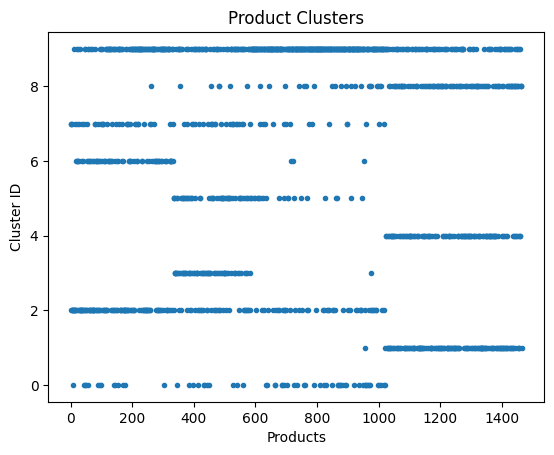

In [2]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Applying K-Means clustering
kmeans = KMeans(n_clusters=10, init='k-means++', max_iter=100, n_init=1)
y_kmeans = kmeans.fit_predict(X)

# Assigning clusters to the dataframe
df['cluster_id'] = y_kmeans
 
# Visualize the product clusters
plt.plot(y_kmeans, ".")
plt.title("Product Clusters")
plt.xlabel("Products")
plt.ylabel("Cluster ID")
plt.show()


## 5. Determining Optimal Number of Clusters using the Elbow Method:

To find the optimal number of clusters, we'll compute the sum of squared distances for different values of `k` and visualize it. The point where the rate of decrease sharply changes (forming an "elbow") represents an optimal value for `k`.


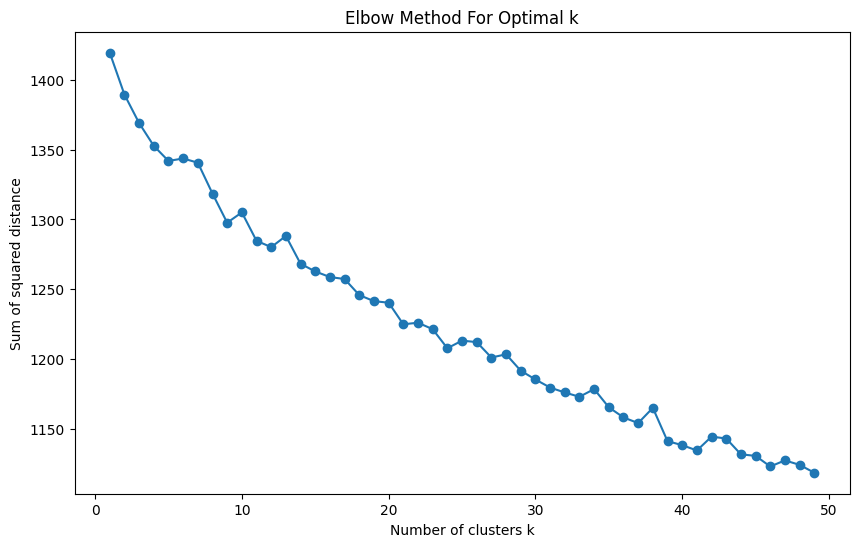

In [3]:
from sklearn.cluster import KMeans

# Sum of squared distances
sse = []

# List of number of clusters to try
k_list = range(1, 100)

for k in k_list:
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=1)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)

# Plotting the results
plt.figure(figsize=(10,6))
plt.plot(k_list, sse, '-o')
plt.xlabel('Number of clusters k')
plt.ylabel('Sum of squared distance')
plt.title('Elbow Method For Optimal k')
plt.show()


## 6. Update MongoDB with Cluster IDs:
Then we shall update the products with their newly created cluster_id in the mongodb database

In [4]:
# import pymongo

# client = pymongo.MongoClient("YOUR_MONGO_CONNECTION_STRING")
# db = client.ecommerceDB  # Access the ecommerceDB database
# collection = db.products  # Access (or create) the products collection

# for index, row in df.iterrows():
#     # Update each product with its cluster_id
#     collection.update_one({"product_id": row["product_id"]}, {"$set": {"cluster_id": int(row["cluster_id"])}})

# client.close()


## 7. Making Recommendations

Our recommendation logic is straightforward:
1. For a given product, determine its cluster.
2. Recommend other products from the same cluster.

Let's define functions to display the characteristic terms of each cluster and to recommend products based on a given product description.


In [5]:
# Function to display top terms per cluster
def print_cluster(i, order_centroids, terms):
    print(f"Cluster {i}:")
    for ind in order_centroids[i, :10]:
        print(terms[ind], end=", ")
    print("\n")

# Displaying top terms for each cluster
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()
for i in range(10):
    print_cluster(i, order_centroids, terms)

# Assigning clusters to the dataframe
df['cluster_id'] = y_kmeans

# Updated Recommendation function
def show_recommendations(product):
    Y = vectorizer.transform([product])
    prediction = kmeans.predict(Y)
    cluster_products = df[df['cluster_id'] == prediction[0]].head(5)
    
    print(f"Recommended products for:\n{product}\n")
    for _, row in cluster_products.iterrows():
        print(f"Product ID: {row['product_id']}")
        print(f"Price: {row['discounted_price']}")
        print(f"Image URL: {row['img_link']}")
        print(f"Description: {row['about_product']}\n")
        print('-'*60)

Cluster 0:
earbuds, earbud, tips, ears, playtime, voice, case, sound, playback, drivers, 

Cluster 1:
remote, tv, led, control, compatible, order, match, quality, placing, mi, 

Cluster 2:
cable, charging, usb, type, data, fast, speed, charge, transfer, devices, 

Cluster 3:
kettle, stainless, steel, water, electric, base, litre, tea, lid, power, 

Cluster 4:
heater, rod, electric, water, halogen, heating, immersion, package, libra, maker, 

Cluster 5:
tv, hdmi, connect, ports, dolby, information, 4k, box, video, apps, 

Cluster 6:
usb, type, cable, charging, transfer, enabled, note, speed, data, devices, 

Cluster 7:
cable, rugged, length, ideal, 480, mbps, bindings, like, affected, interior, 

Cluster 8:
eggs, egg, boiler, boiling, measuring, water, cup, frying, firmness, soft, 

Cluster 9:
iphone, plus, ipod, ipad, durability, sync, 6s, nylon, multilayer, charge, 



In [6]:
# You can replace the argument with any product description from your dataset
show_recommendations("hdmi cable for 4K video streaming")

Recommended products for:
hdmi cable for 4K video streaming



## 6. Conclusion

We've implemented a content-based recommendation system
